In [1]:
%load_ext cython

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import multiprocessing as mp
import random
from multiprocessing import Pool
import os
from tqdm import tqdm
from IPython.display import clear_output
import glob
print("Number of processors: ", mp.cpu_count())
n_process = mp.cpu_count()

Number of processors:  48


In [3]:
%%cython -+ 
cimport cython
import numpy as np
cimport numpy as np

from mc_lib.observable cimport RealObservable

def binning(measurements):
    
    cdef RealObservable msms = RealObservable()
    
    for m in measurements:
         msms.add_measurement(m)

    return (msms.mean, msms.errorbar) # получается выборка из не более чем 1000 значений - средних по блокам
                                # чем больше измерений, тем больше размер блоков
    

In [3]:
# корни из уравнения в другом файле
roots = [2.2691853142129728, 2.104982167992544, 1.932307699120554, 1.749339162933206, 1.5536238493280832, 1.34187327905057, 1.109960313758399, 0.8541630993606272, 0.5762735442012712, 0.2885386111960936, 0.03198372863548067]
jds = [0.0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0]
get_crit_T = dict(zip(jds,roots))

In [4]:
Jd = 0
round(get_crit_T[Jd],3)

2.269

In [6]:
def bind(magn):
    
    m2 = magn**2
    m4 = magn**4
    
    m4_mean, m4_err = binning(m4)
    m2_mean, m2_err = binning(m2)
    
    binder = 1 - (m4_mean) / (3 * (m2_mean**2))
    
    error = np.sqrt( ( m4_err/( 3*(m2_mean**2)) )**2 + ( 2*(m4_mean)*m2_err/(3*(m2_mean**3) ) )**2 )
    
    return (binder, error)

In [7]:
# это работет 8 min
Jd = -0.5

T_crit = round(get_crit_T[Jd],3)
Temps = np.linspace(T_crit - 0.01, T_crit + 0.01, 8)
N = 40
T = len(Temps)

binder_120 = np.zeros((N,T))
binder_20 = np.zeros((N,T))
binder_40 = np.zeros((N,T))
binder_80 = np.zeros((N,T))

err_120 = np.zeros((N,T))
err_20 = np.zeros((N,T))
err_40 = np.zeros((N,T))
err_80 = np.zeros((N,T))

for tt,t in tqdm(enumerate(Temps)):
    for i,name in enumerate(glob.glob(f'./data_{Jd:.1f}/magn_40_{t:.3f}_{Jd:.1f}_*.npy')):
        print(name)
        m = np.load(name)
        binder_40[i,tt], err_40[i,tt] = bind(m)
        
    for i,name in enumerate(glob.glob(f'./data_{Jd:.1f}/magn_20_{t:.3f}_{Jd:.1f}_*.npy')):
        print(name)
        m = np.load(name)
        binder_20[i,tt], err_20[i,tt] = bind(m)
        
    for i,name in enumerate(glob.glob(f'./data_{Jd:.1f}/magn_80_{t:.3f}_{Jd:.1f}_*.npy')):
        print(name)
        m = np.load(name)
        binder_80[i,tt], err_80[i,tt] = bind(m)
        
    for i,name in enumerate(glob.glob(f'./data_{Jd:.1f}/magn_120_{t:.3f}_{Jd:.1f}_*.npy')):
        print(name)
        m = np.load(name)
        binder_120[i,tt], err_120[i,tt] = bind(m)
        
    clear_output()
    
    
res = np.zeros((N,2,4,T)) # массив (N,2,4,T), где 2 - это пара (средн., ошибка), 4 - количество размеров L
for i in range(N):
    res[i,0,0] = binder_120[i]
    res[i,0,1] = binder_20[i]
    res[i,0,2] = binder_40[i]
    res[i,0,3] = binder_80[i] 
    
    res[i,1,0] = err_120[i]  
    res[i,1,1] = err_20[i]  
    res[i,1,2] = err_40[i] 
    res[i,1,3] = err_80[i] 
    
np.save(f'res_{Jd:.1f}_b.npy', res)

8it [08:03, 60.47s/it]


In [6]:
def calculate_distribution(Bs, dBs):
    
    N = len(Bs) 
    # В измерен N раз с ошибкой
    
    Norms = np.zeros((N,1000))
    
    for i in range(N):
        for j in range(1000):
            Norms[i,j] = random.normalvariate(mu = Bs[i], sigma = dBs[i]) 
            # генерируем N выборок обьемом 1000 из норм. распределения с соотв. матожиданием и отклонением
    
    Norm = np.zeros(1000)
    for i in range(1000):
        Norm[i] = np.mean([Norms[_,i] for _ in range(N)]) 
        # усредняем выборки, получаем распределение с какими то усредненными матожиданием и дисперсией
    
    return (np.mean(Norm), np.std(Norm)) # полученные матож. и дисперсия     

In [79]:
Jd = -0.7
res = np.load(f'res_{Jd:.1f}_b.npy')

T_crit = round(get_crit_T[Jd],3)
Temps = np.linspace(T_crit - 0.01, T_crit + 0.01, 8)
N = 40
T = len(Temps)

binder_120 = np.zeros((N,T))
binder_20 = np.zeros((N,T))
binder_40 = np.zeros((N,T))
binder_80 = np.zeros((N,T))

err_120 = np.zeros((N,T))
err_20 = np.zeros((N,T))
err_40 = np.zeros((N,T))
err_80 = np.zeros((N,T))

for i in range(N):
    binder_120[i] = res[i,0,0]
    binder_20[i] = res[i,0,1]
    binder_40[i] = res[i,0,2]
    binder_80[i] = res[i,0,3]
    
    err_120[i] = res[i,1,0]
    err_20[i] = res[i,1,1]
    err_40[i] = res[i,1,2]
    err_80[i] = res[i,1,3]

In [80]:
B120 = np.zeros(T)
ErrB120 = np.zeros(T)

B20 = np.zeros(T)
ErrB20 = np.zeros(T)

B40 = np.zeros(T)
ErrB40 = np.zeros(T)

B80 = np.zeros(T)
ErrB80 = np.zeros(T)

for i in range(T):
    B120s = [binder_120[_,i] for _ in range(N)]
    dB120s = [err_120[_,i] for _ in range(N)]
    B120[i], ErrB120[i] = calculate_distribution(B120s, dB120s)
    
    B20s = [binder_20[_,i] for _ in range(N)]
    dB20s = [err_20[_,i] for _ in range(N)]
    B20[i], ErrB20[i] = calculate_distribution(B20s, dB20s)
    
    B40s = [binder_40[_,i] for _ in range(N)]
    dB40s = [err_40[_,i] for _ in range(N)]
    B40[i], ErrB40[i] = calculate_distribution(B40s, dB40s)
    
    B80s = [binder_80[_,i] for _ in range(N)]
    dB80s = [err_80[_,i] for _ in range(N)]
    B80[i], ErrB80[i] = calculate_distribution(B80s, dB80s)

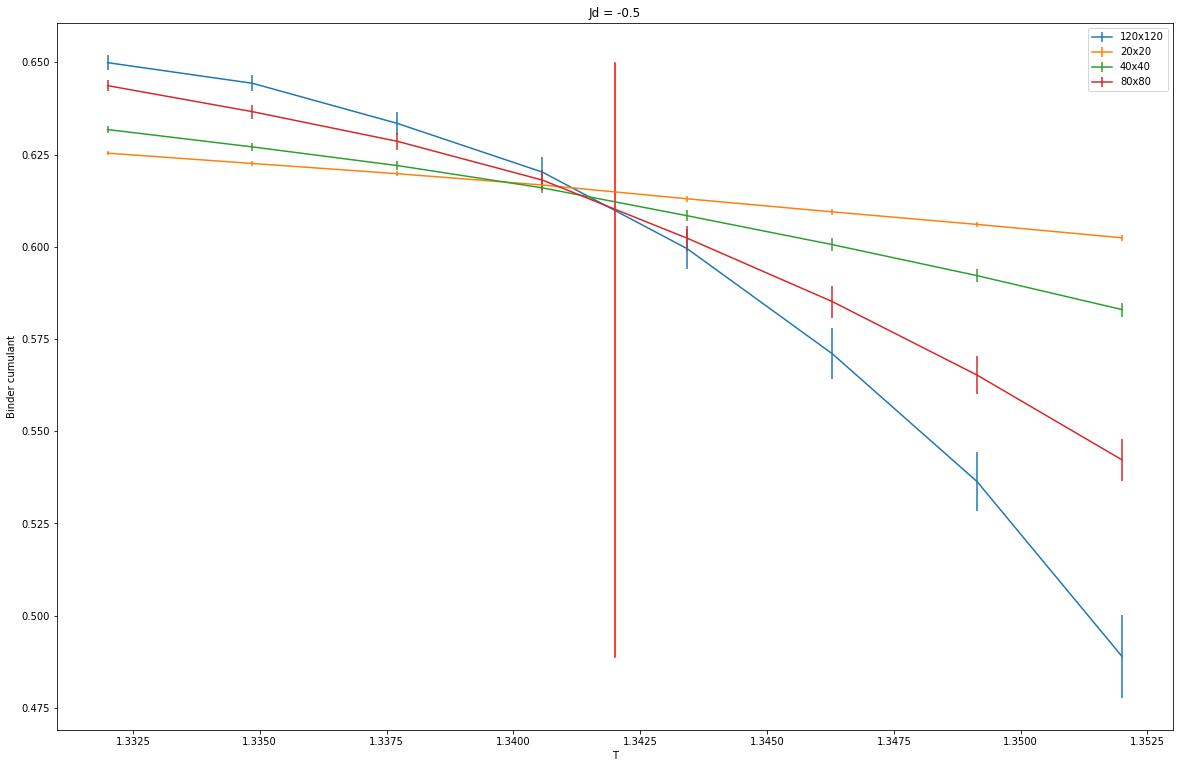

In [8]:

plt.figure(figsize=(20,13))
plt.errorbar(Temps, B120, yerr = ErrB120, label = '120x120')
plt.errorbar(Temps, B20, yerr = ErrB20, label = '20x20')
plt.errorbar(Temps, B40, yerr = ErrB40, label = '40x40')
plt.errorbar(Temps, B80, yerr = ErrB80, label = '80x80')
plt.plot([T_crit]*20, np.linspace(B120[0], B120[-1], 20), c = 'r')
plt.legend()
plt.title(f'Jd = {Jd}')

plt.xlabel("T")
plt.ylabel("Binder cumulant")
plt.show()

In [67]:
l120 = np.zeros(100)
r120 = np.zeros(100)
l80 = np.zeros(100)
r80 = np.zeros(100)
l40 = np.zeros(100)
r40 = np.zeros(100)
    
for i in range(100):
    l120[i] = random.normalvariate(mu = B120[2], sigma = ErrB120[2]) 
    r120[i] = random.normalvariate(mu = B120[5], sigma = ErrB120[5]) 
    l80[i] = random.normalvariate(mu = B80[2], sigma = ErrB80[2]) 
    r80[i] = random.normalvariate(mu = B80[5], sigma = ErrB80[5]) 
    l40[i] = random.normalvariate(mu = B40[2], sigma = ErrB40[2]) 
    r40[i] = random.normalvariate(mu = B40[5], sigma = ErrB40[5]) 

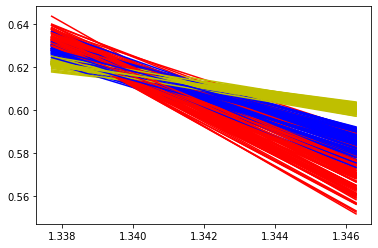

In [50]:
# 100 синтетических точек
for i in range(100):
    plt.plot([Temps[2],Temps[5]],[l120[i],r120[i]], c = 'r')
    plt.plot([Temps[2],Temps[5]],[l80[i],r80[i]], c = 'b')
    plt.plot([Temps[2],Temps[5]],[l40[i],r40[i]], c = 'y')

In [25]:
from __future__ import division 

def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x,y
    else:
        return False

In [27]:
L1 = line([Temps[2],l120[0]], [Temps[5],r120[0]])
L2 = line([Temps[2],l80[0]], [Temps[5],r80[0]])

R = intersection(L1, L2)
if R:
    print("Intersection detected:", R)
else:
    print( "No single intersection point detected")

Intersection detected: (1.3393267830465703, 0.6175288354063093)


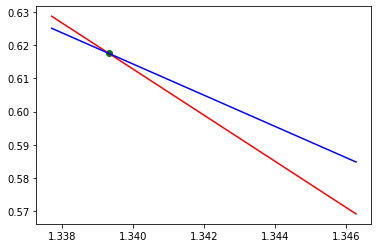

In [32]:
for i in range(1):
    plt.plot([Temps[2],Temps[5]],[l120[i],r120[i]], c = 'r')
    plt.plot([Temps[2],Temps[5]],[l80[i],r80[i]], c = 'b')
    plt.scatter(R[0],R[1], c = 'g')

In [81]:
points_80 = []
out_80 = 0
points_40 = []
out_40 = 0

for i in range(100):
    L1 = line([Temps[2],l120[i]], [Temps[5],r120[i]])
    L2 = line([Temps[2],l80[i]], [Temps[5],r80[i]])
    L3 = line([Temps[2],l40[i]], [Temps[5],r40[i]])
    R_80 = intersection(L1, L2)
    R_40 = intersection(L1, L3)
    if R_80:
        points_80.append(R_80[0])
    else:
        out_80+=1
    if R_40:
        points_40.append(R_40[0])
    else:
        out_40+=1

In [82]:
print(out_80,out_40)

0 0


In [63]:
print("T_c = ",  round(get_crit_T[Jd],3), f"(J_d = {Jd})")
print("120 x 80: T = ", round(np.mean(points_80),4), "+-", round(np.std(points_80),4))    
print("120 x 40: T = ", round(np.mean(points_40),4), "+-", round(np.std(points_40),4))   

T_c =  1.342 (J_d = -0.5)
120 x 80: T =  1.341 +- 0.009
120 x 40: T =  1.3401 +- 0.0008


In [71]:
print("T_c = ",  round(get_crit_T[Jd],3), f"(J_d = {Jd})")
print("120 x 80: T = ", round(np.mean(points_80),4), "+-", round(np.std(points_80),2))    
print("120 x 40: T = ", round(np.mean(points_40),4), "+-", round(np.std(points_40),4))   

T_c =  1.749 (J_d = -0.3)
120 x 80: T =  1.7431 +- 0.04
120 x 40: T =  1.7482 +- 0.0008


In [78]:
print("T_c = ",  round(get_crit_T[Jd],3), f"(J_d = {Jd})")
print("120 x 80: T = ", round(np.mean(points_80),4), "+-", round(np.std(points_80),2))    
print("120 x 40: T = ", round(np.mean(points_40),4), "+-", round(np.std(points_40),4))  

T_c =  2.269 (J_d = 0.0)
120 x 80: T =  2.2631 +- 0.04
120 x 40: T =  2.2682 +- 0.0008


In [83]:
print("T_c = ",  round(get_crit_T[Jd],3), f"(J_d = {Jd})")
print("120 x 80: T = ", round(np.mean(points_80),4), "+-", round(np.std(points_80),2))    
print("120 x 40: T = ", round(np.mean(points_40),4), "+-", round(np.std(points_40),4))  

T_c =  0.854 (J_d = -0.7)
120 x 80: T =  0.8481 +- 0.04
120 x 40: T =  0.8532 +- 0.0008
